# Skin Condition Image Network

## Introduction

The dataset used for predictive model training, SCIN (Skin Condition Image Network), was sourced from voluntary contributions by Google Search users in the United States over 8 months starting March 2023. It encompasses over 5,000 contributions comprising more than 10,000 images of various dermatological conditions. Each contribution includes self-reported demographic details, medical history, symptoms, and Fitzpatrick skin type (sFST). Additionally, dermatologist labels for skin conditions and estimated Fitzpatrick skin types (eFST), along with layperson estimated Monk Skin tone (eMST) labels, are provided. The data is stored on Google Cloud Storage in the dx-scin-public-data bucket. Despite its richness, the dataset does have known issues, notably 15 duplicate images that appear a total of 42 times and 48 cases where no skin condition label is present despite being marked as gradable, likely due to the presence of multiple conditions. This dataset offers a diverse array of dermatology images and associated information, making it a valuable resource for training predictive models in dermatological diagnosis and research.

### Exploratory Data Analysis

#### 1. Import required libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Conv2DTranspose, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import os
import ast

#### 2. Loading the Dataset

In [2]:
cases_df = pd.read_csv(r"dataset_scin_cases.csv")
labels_df = pd.read_csv(r"dataset_scin_labels.csv")


#### 3. Overview of Data Types and Statistics 
Start by getting an overview of the data types and some statistical summaries to understand the nature of the data.

In [3]:
# dataset_scin_cases data info
print(cases_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 57 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   case_id                                             5033 non-null   int64 
 1   source                                              5033 non-null   object
 2   release                                             5033 non-null   object
 3   year                                                5033 non-null   int64 
 4   age_group                                           5032 non-null   object
 5   sex_at_birth                                        5032 non-null   object
 6   fitzpatrick_skin_type                               2503 non-null   object
 7   race_ethnicity_american_indian_or_alaska_native     73 non-null     object
 8   race_ethnicity_asian                                96 non-null     object
 9   race_eth

In [4]:
# dataset_scin_labels data info
print(labels_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5033 entries, 0 to 5032
Data columns (total 17 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   case_id                                             5033 non-null   int64  
 1   dermatologist_gradable_for_skin_condition_1         5033 non-null   object 
 2   dermatologist_gradable_for_skin_condition_2         716 non-null    object 
 3   dermatologist_gradable_for_skin_condition_3         716 non-null    object 
 4   dermatologist_skin_condition_on_label_name          5033 non-null   object 
 5   dermatologist_skin_condition_confidence             5033 non-null   object 
 6   weighted_skin_condition_label                       5033 non-null   object 
 7   dermatologist_gradable_for_fitzpatrick_skin_type_1  5033 non-null   object 
 8   dermatologist_gradable_for_fitzpatrick_skin_type_2  716 non-null    object 
 9

In [5]:
# Printing descriptive statistics for the DataFrame 'cases_df', including both numeric and categorical columns.
print(cases_df.describe(include='all'))

             case_id source release    year    age_group  \
count   5.033000e+03   5033    5033  5033.0         5032   
unique           NaN      1       1     NaN            7   
top              NaN   SCIN   1.0.0     NaN  AGE_UNKNOWN   
freq             NaN   5033    5033     NaN         2864   
mean   -2.487811e+16    NaN     NaN  2023.0          NaN   
std     5.322911e+18    NaN     NaN     0.0          NaN   
min    -9.223126e+18    NaN     NaN  2023.0          NaN   
25%    -4.654656e+18    NaN     NaN  2023.0          NaN   
50%    -6.204642e+16    NaN     NaN  2023.0          NaN   
75%     4.543631e+18    NaN     NaN  2023.0          NaN   
max     9.222737e+18    NaN     NaN  2023.0          NaN   

                sex_at_birth fitzpatrick_skin_type  \
count                   5032                  2503   
unique                     3                     7   
top     OTHER_OR_UNSPECIFIED                  FST3   
freq                    2559                   661   
mean     

In [6]:
# Similarly, Printing descriptive statistics for the DataFrame 'labels_df', including both numeric and categorical columns.
print(labels_df.describe(include='all'))

             case_id dermatologist_gradable_for_skin_condition_1  \
count   5.033000e+03                                        5033   
unique           NaN                                           3   
top              NaN        DEFAULT_YES_IMAGE_QUALITY_SUFFICIENT   
freq             NaN                                        3049   
mean   -2.487811e+16                                         NaN   
std     5.322911e+18                                         NaN   
min    -9.223126e+18                                         NaN   
25%    -4.654656e+18                                         NaN   
50%    -6.204642e+16                                         NaN   
75%     4.543631e+18                                         NaN   
max     9.222737e+18                                         NaN   

       dermatologist_gradable_for_skin_condition_2  \
count                                          716   
unique                                           3   
top           DEFAULT

##### Distribution of Skin Types and Conditions

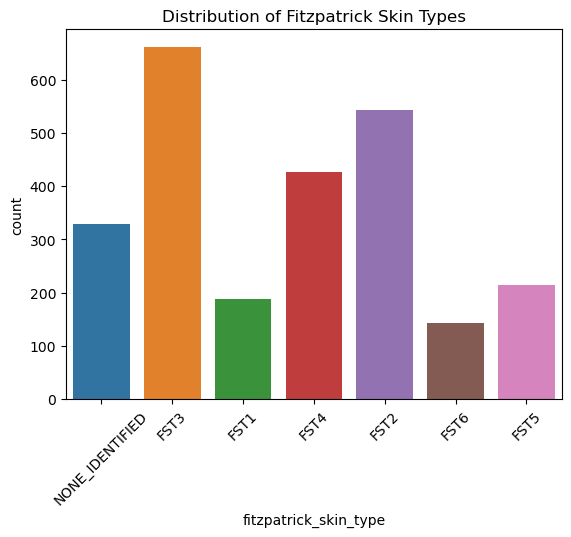

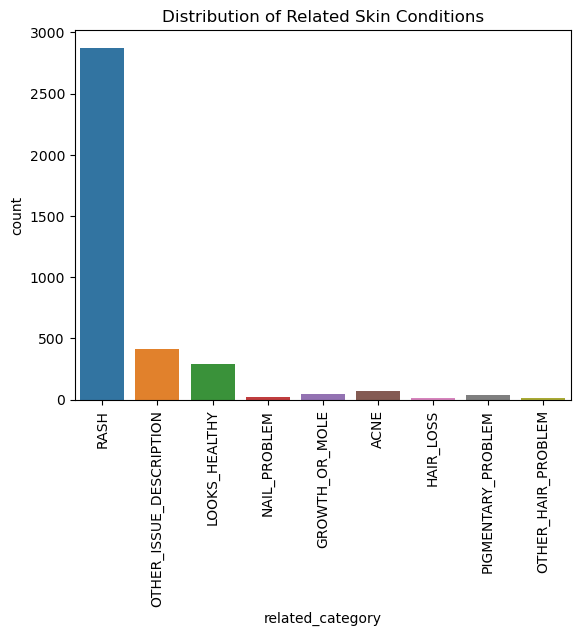

In [7]:
# Distribution of Fitzpatrick skin types
sns.countplot(x='fitzpatrick_skin_type', data=cases_df)
plt.title('Distribution of Fitzpatrick Skin Types')
plt.xticks(rotation=45)
plt.show()

# Distribution of conditions
sns.countplot(x='related_category', data=cases_df)
plt.title('Distribution of Related Skin Conditions')
plt.xticks(rotation=90)
plt.show()

##### Checking if any missing values

In [8]:
# Check for missing values
print(cases_df.isnull().sum())
print(labels_df.isnull().sum())

case_id                                                  0
source                                                   0
release                                                  0
year                                                     0
age_group                                                1
sex_at_birth                                             1
fitzpatrick_skin_type                                 2530
race_ethnicity_american_indian_or_alaska_native       4960
race_ethnicity_asian                                  4937
race_ethnicity_black_or_african_american              4735
race_ethnicity_hispanic_latino_or_spanish_origin      4743
race_ethnicity_middle_eastern_or_north_african        5026
race_ethnicity_native_hawaiian_or_pacific_islander    5029
race_ethnicity_white                                  3160
race_ethnicity_other_race                             5017
race_ethnicity_prefer_not_to_answer                   4999
textures_raised_or_bumpy                              21

##### Plotting missing values

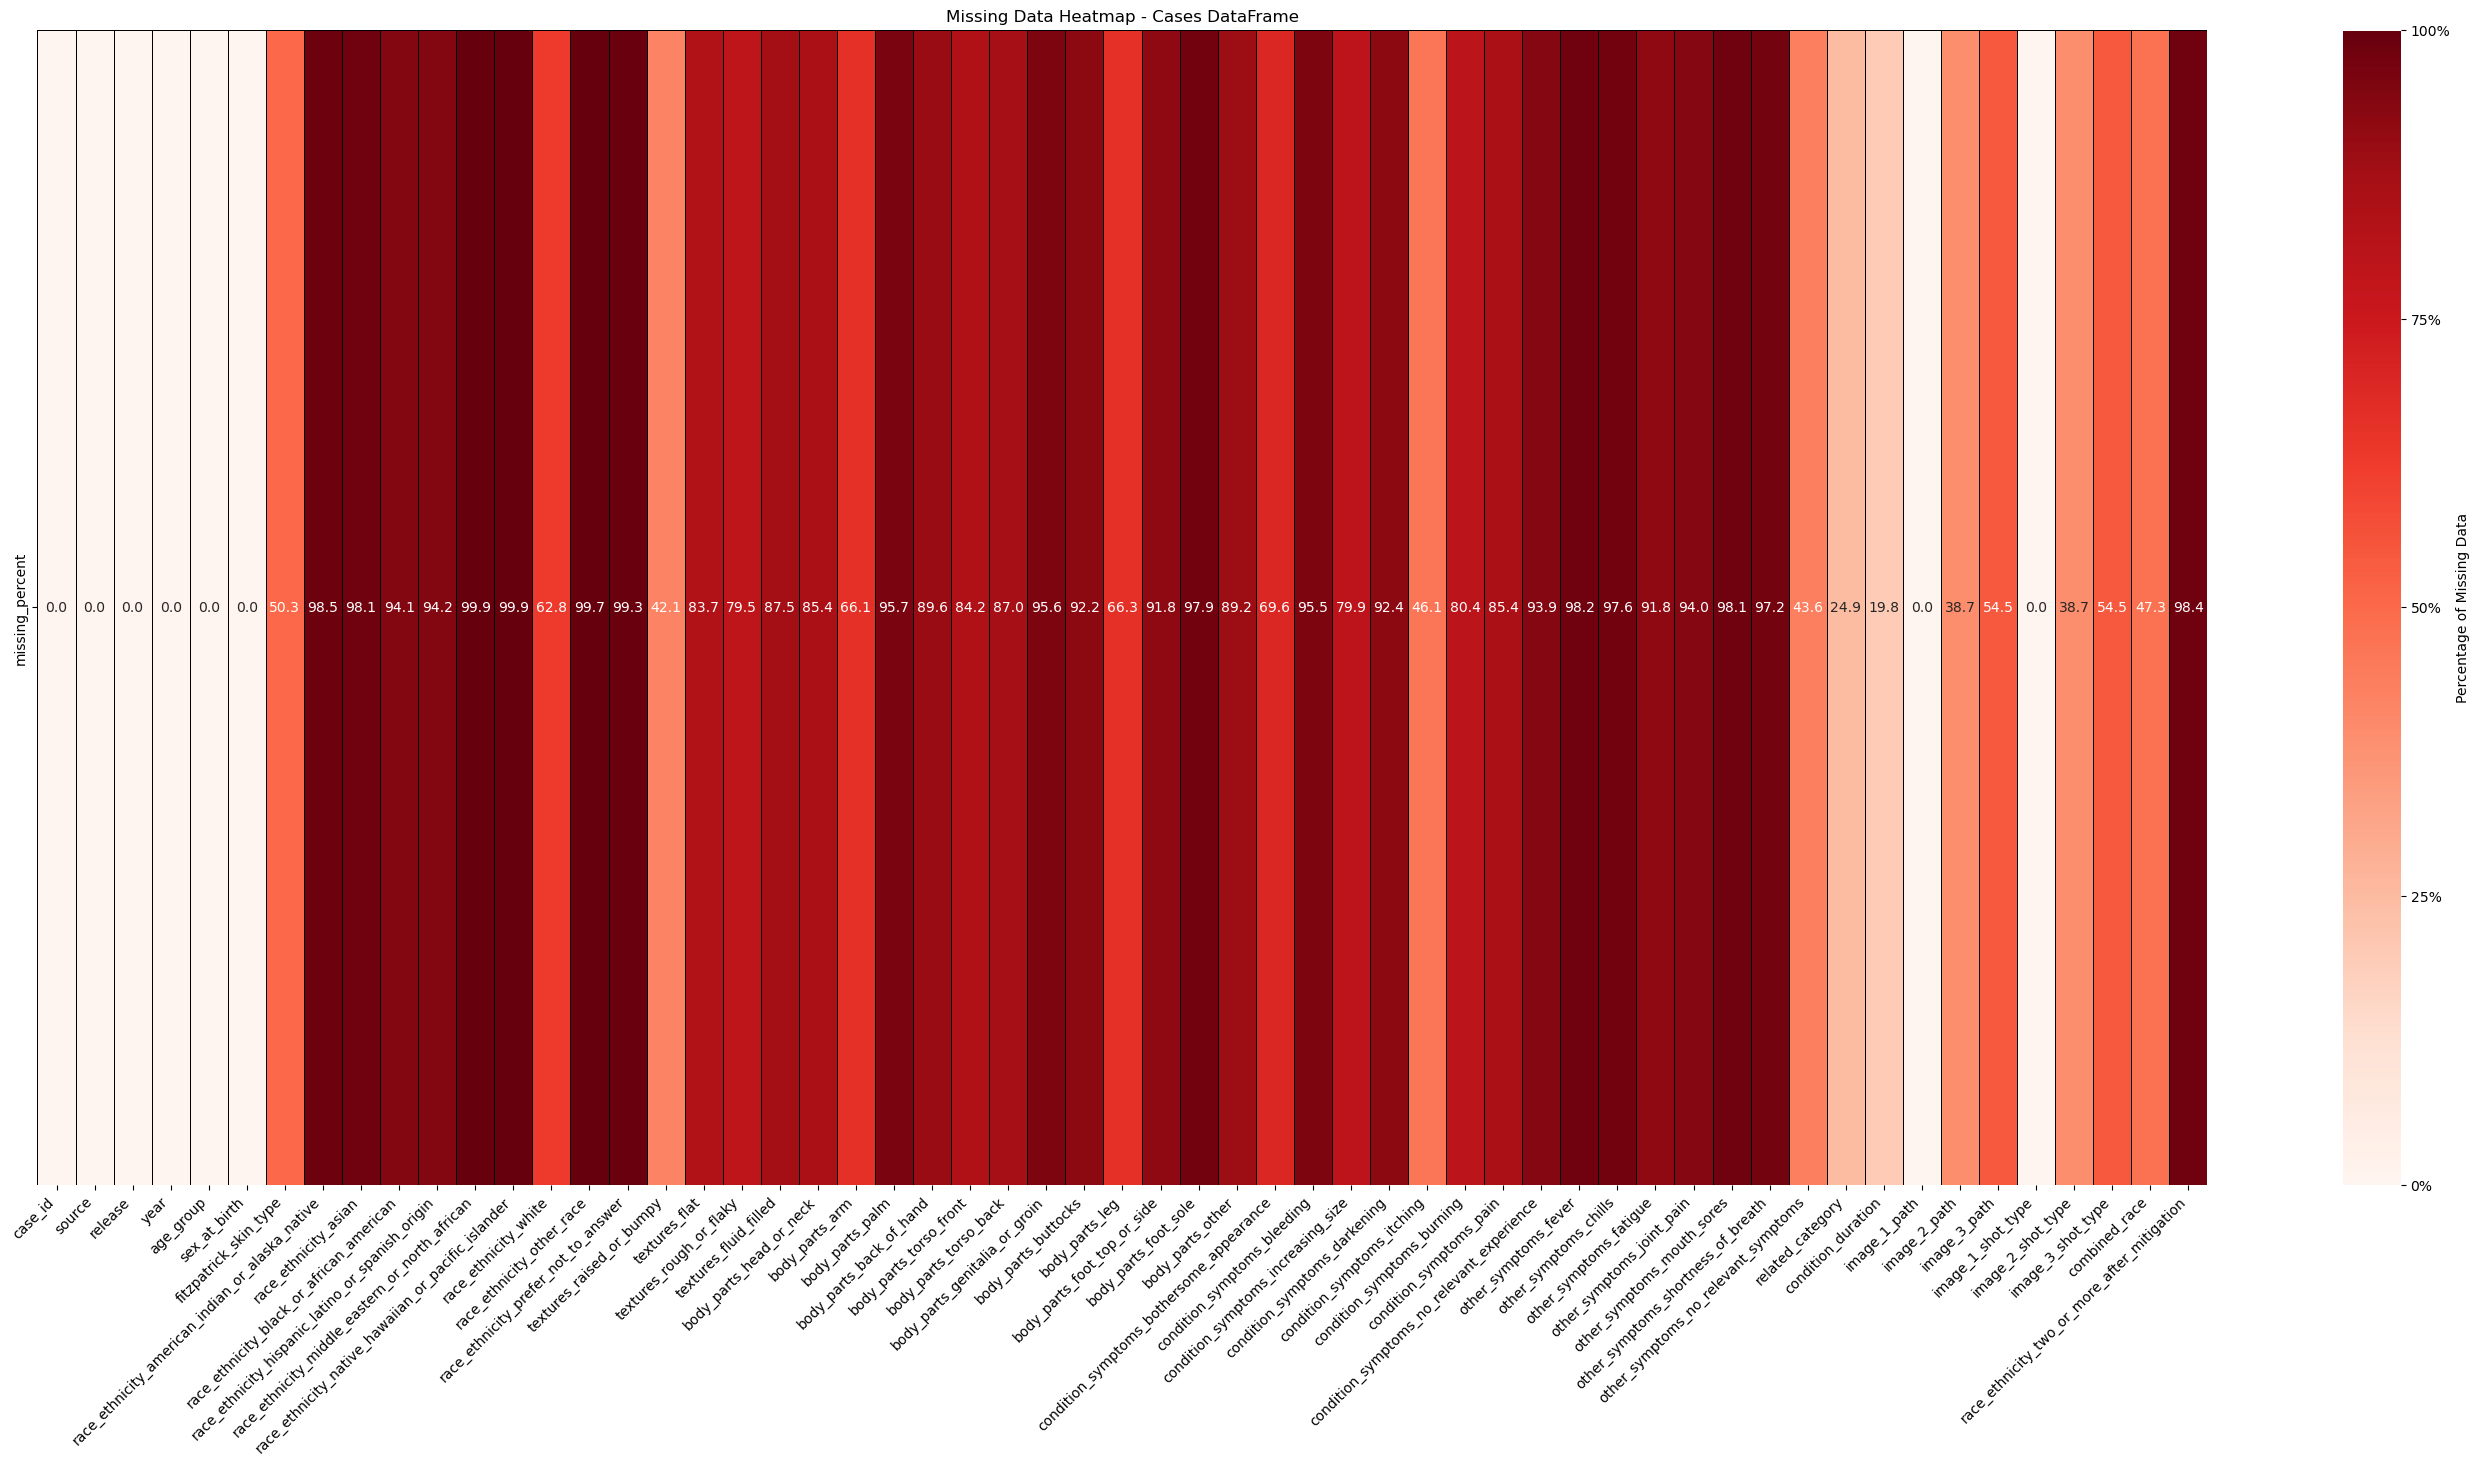

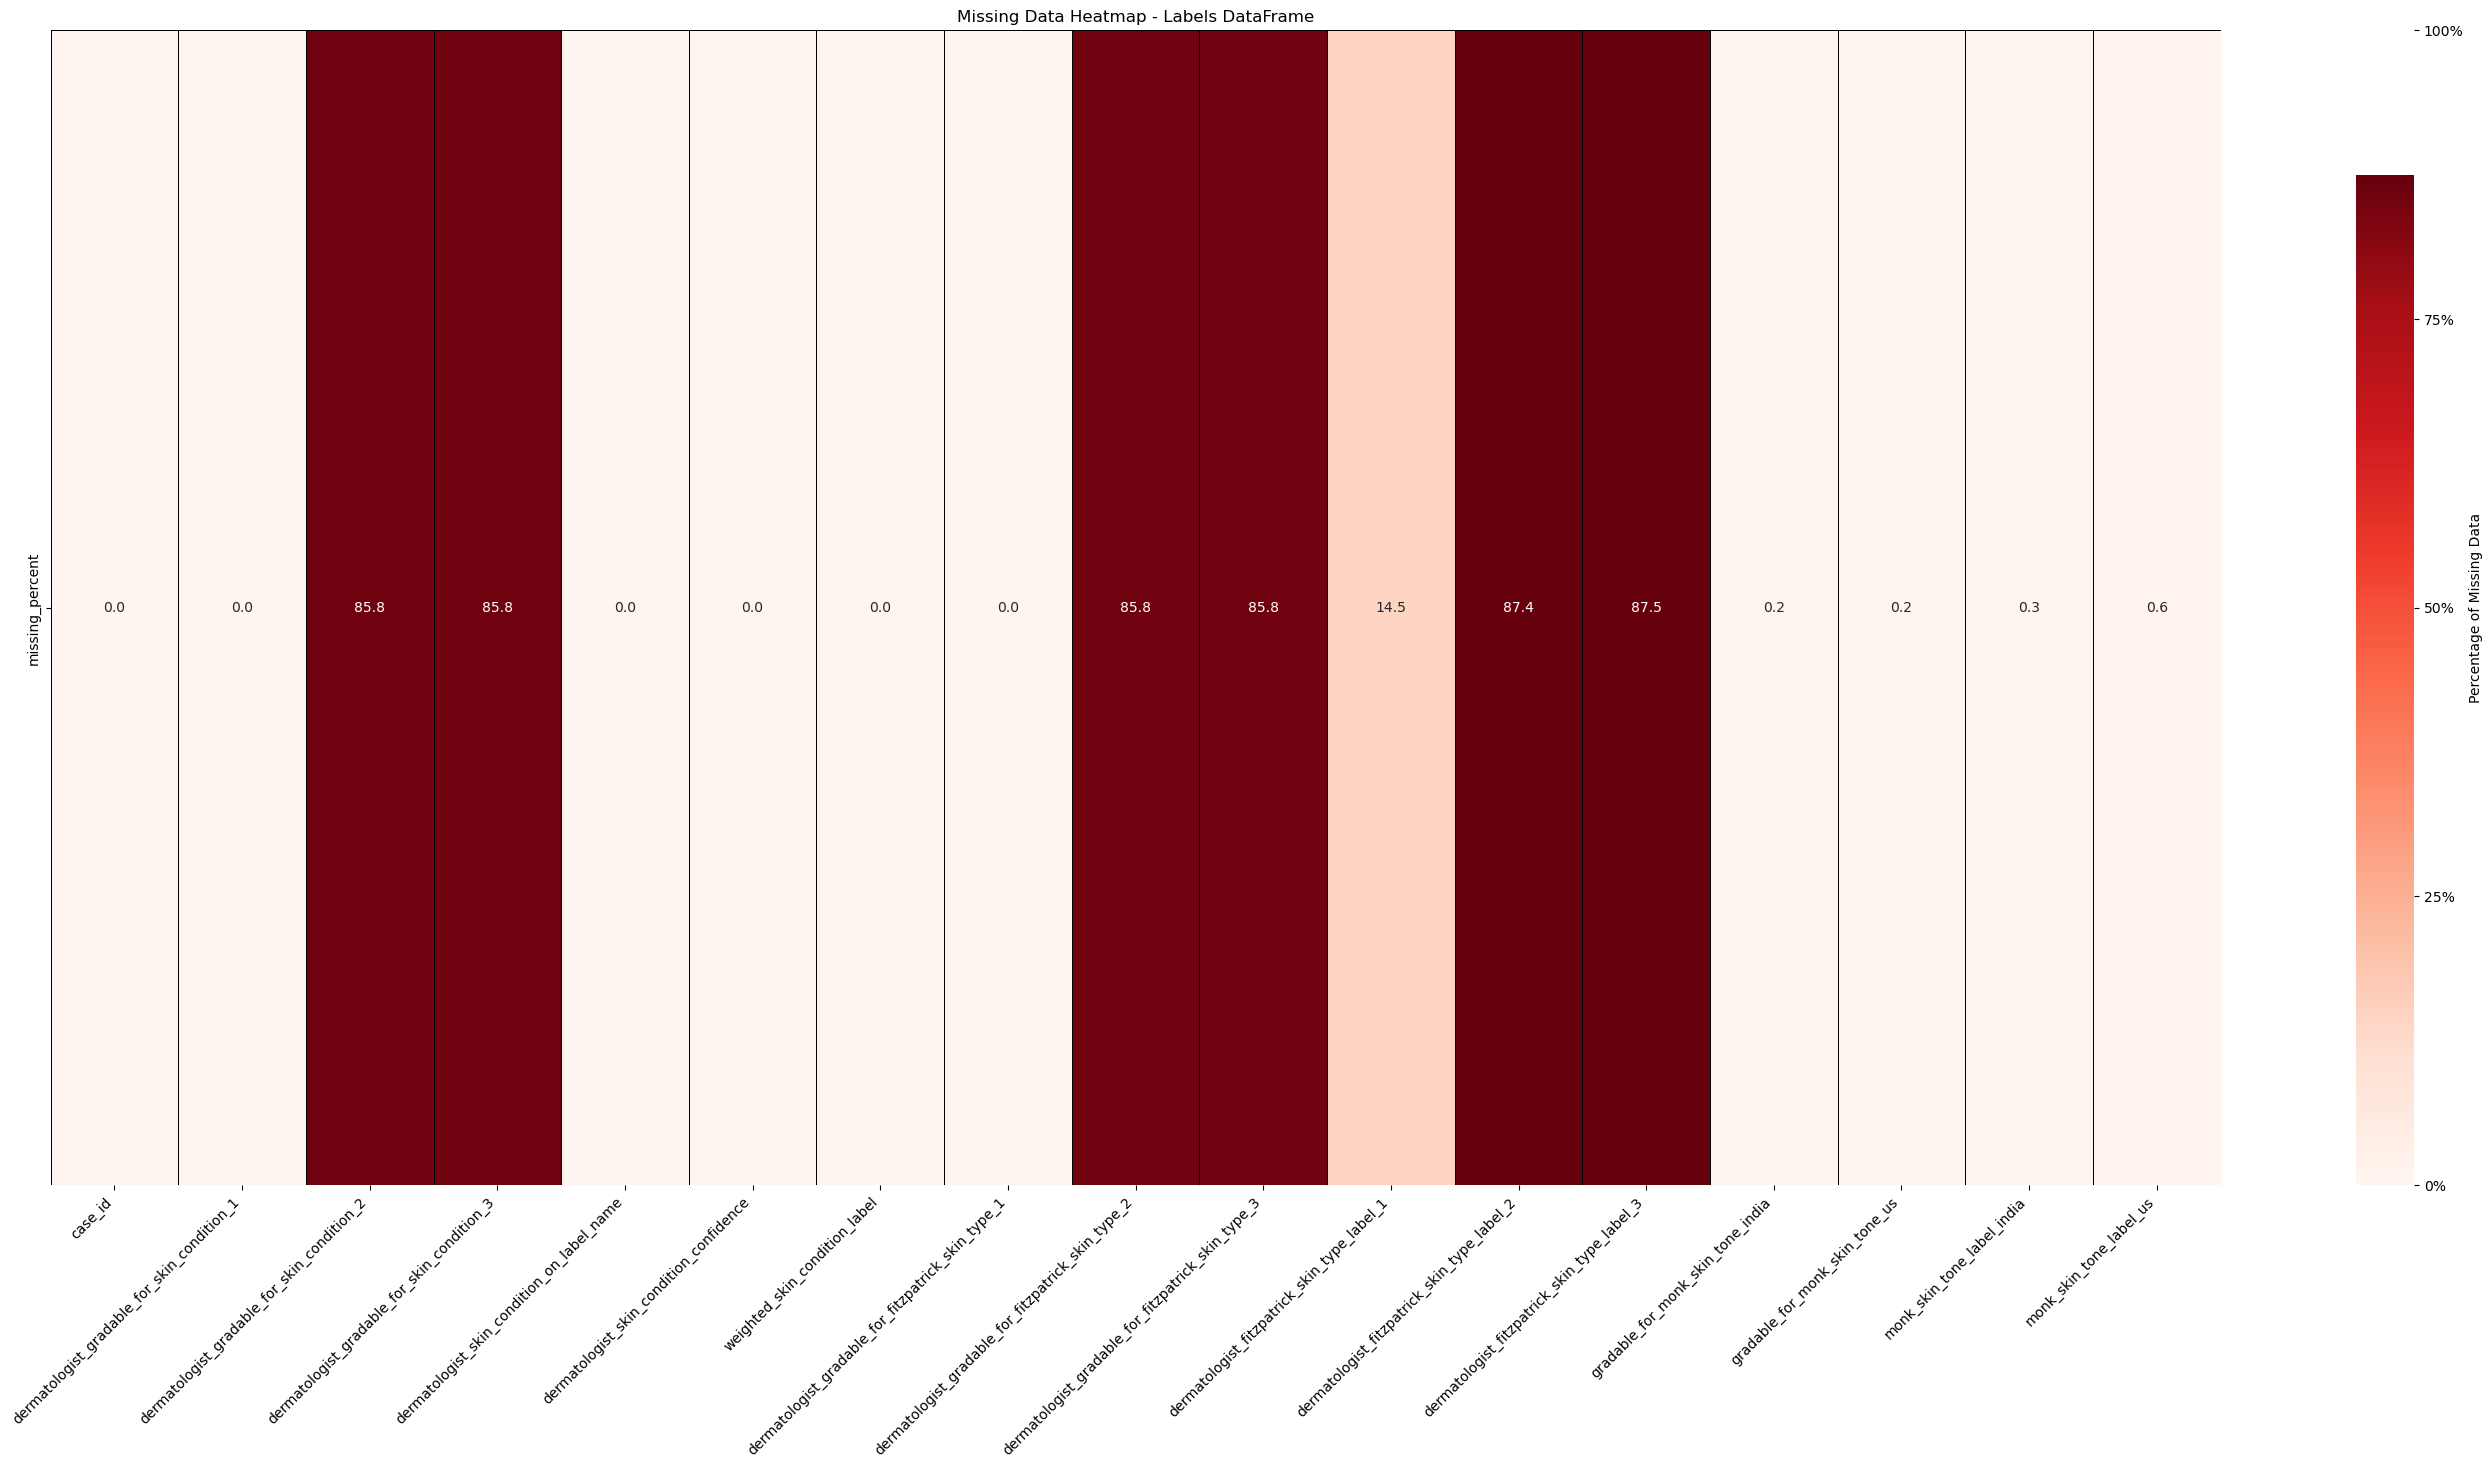

In [9]:
#Enhanced Missing Data Heatmap with Annotations
def plot_missing_data_heatmap(df, title):
    # Calculate the percentage of missing data in each column
    missing_data = df.isnull().mean() * 100
    # Create a DataFrame to visualize
    missing_data_df = pd.DataFrame(missing_data, columns=['missing_percent'])
    missing_data_df = missing_data_df.transpose()
    # Plotting
    plt.figure(figsize=(35, 15))
    ax = sns.heatmap(missing_data_df, annot=True, fmt=".1f", cmap='Reds', cbar=True, cbar_kws={'label': 'Percentage Missing (%)'}, linewidths=0.5, linecolor='black')
    colorbar = ax.collections[0].colorbar
    colorbar.set_label('Percentage of Missing Data')
    colorbar.set_ticks([0, 25, 50, 75, 100])
    colorbar.set_ticklabels(['0%', '25%', '50%', '75%', '100%'])
    plt.title(title)
    plt.xticks(rotation=45, ha='right')  # Rotate column names for better visibility
    plt.show()

# Usage with example DataFrames (replace 'cases_df' and 'labels_df' with your actual DataFrame names if different)
plot_missing_data_heatmap(cases_df, 'Missing Data Heatmap - Cases DataFrame')
plot_missing_data_heatmap(labels_df, 'Missing Data Heatmap - Labels DataFrame')


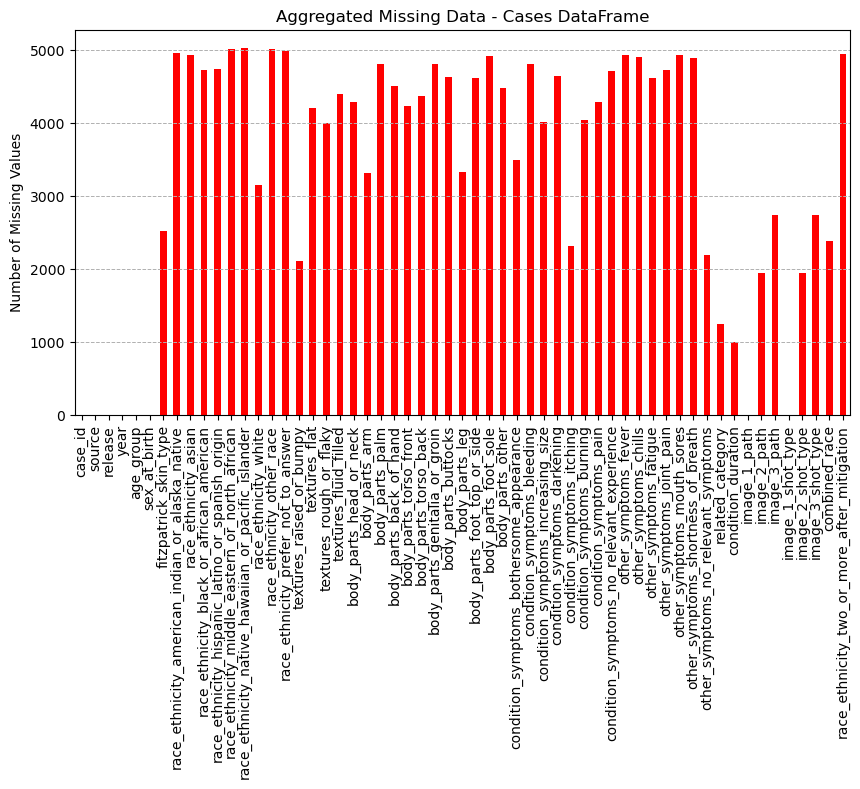

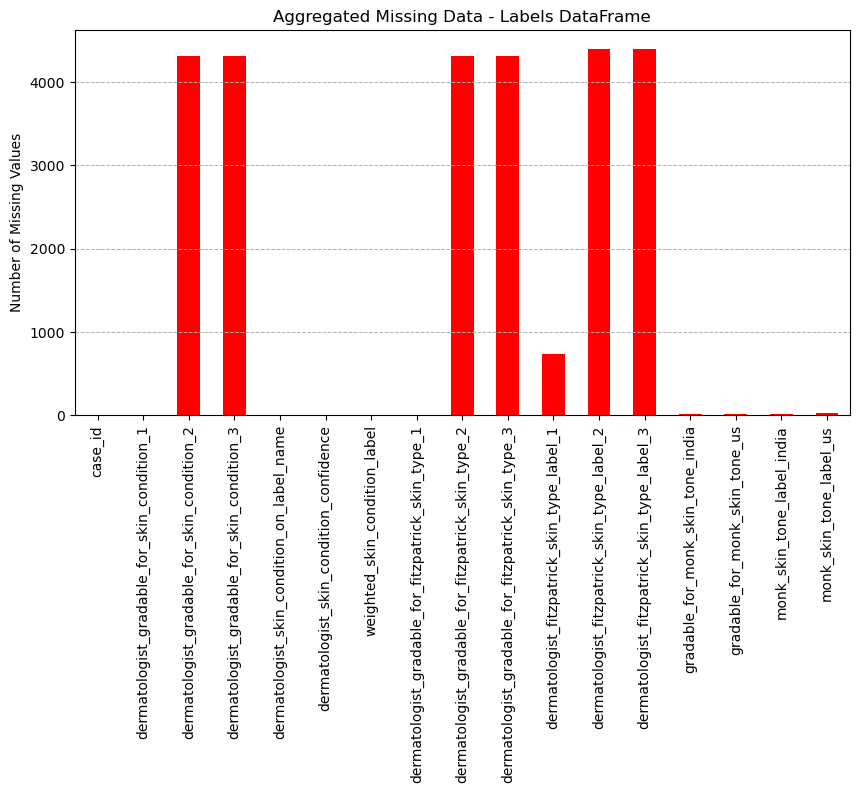

In [10]:
# Aggregated View of Missing Data
def plot_missing_data_aggregated(df, title):
    # Count the number of missing data points in each column
    missing_counts = df.isnull().sum()
    # Plotting
    plt.figure(figsize=(10, 5))  # Adjust size as needed
    missing_counts.plot(kind='bar', color='red')
    plt.title(title)
    plt.ylabel('Number of Missing Values')
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', linewidth=0.7)
    plt.show()

plot_missing_data_aggregated(cases_df, 'Aggregated Missing Data - Cases DataFrame')
plot_missing_data_aggregated(labels_df, 'Aggregated Missing Data - Labels DataFrame')

### Handling Missing data & Unwanted Columns

##### For Cases_df dataset

In [11]:
# Dropping unwanted columns 
cases_df.drop(['source', 'release', 'combined_race', 'race_ethnicity_two_or_more_after_mitigation', 'image_1_shot_type', 'image_2_shot_type', 'image_3_shot_type', 'image_2_path', 'image_3_path'], axis=1, inplace=True)

In [12]:
# List of columns to fill with required values

cases_df['fitzpatrick_skin_type'].fillna('NONE_IDENTIFIED', inplace=True)
cases_df['related_category'].fillna('NONE_MENTIONED', inplace=True)
cases_df['condition_duration'].fillna('UNKNOWN', inplace=True)


# List of columns to fill with 'NO'

columns_to_fill_no = [
'race_ethnicity_american_indian_or_alaska_native',
'race_ethnicity_asian',
'race_ethnicity_black_or_african_american',
'race_ethnicity_hispanic_latino_or_spanish_origin',
'race_ethnicity_middle_eastern_or_north_african',
'race_ethnicity_native_hawaiian_or_pacific_islander',
'race_ethnicity_white',
'race_ethnicity_other_race',
'race_ethnicity_prefer_not_to_answer',
'textures_raised_or_bumpy',
'textures_flat',
'textures_rough_or_flaky',
'textures_fluid_filled',
'body_parts_head_or_neck',
'body_parts_arm',
'body_parts_palm',
'body_parts_back_of_hand',
'body_parts_torso_front',
'body_parts_torso_back',
'body_parts_genitalia_or_groin',
'body_parts_buttocks',
'body_parts_leg',
'body_parts_foot_top_or_side',
'body_parts_foot_sole',
'body_parts_other',
'condition_symptoms_bothersome_appearance',
'condition_symptoms_bleeding',
'condition_symptoms_increasing_size',
'condition_symptoms_darkening',
'condition_symptoms_itching',
'condition_symptoms_burning',
'condition_symptoms_pain',
'condition_symptoms_no_relevant_experience',
'other_symptoms_fever',
'other_symptoms_chills',
'other_symptoms_fatigue',
'other_symptoms_joint_pain',
'other_symptoms_mouth_sores',
'other_symptoms_shortness_of_breath',
'other_symptoms_no_relevant_symptoms'
]
cases_df[columns_to_fill_no] = cases_df[columns_to_fill_no].fillna('NO')

##### For labels_df dataset

In [13]:
# Dropping unwanted columns 
labels_df= labels_df.drop(['dermatologist_gradable_for_skin_condition_1','dermatologist_gradable_for_skin_condition_2', 'dermatologist_gradable_for_skin_condition_3','dermatologist_skin_condition_confidence','dermatologist_fitzpatrick_skin_type_label_2','dermatologist_fitzpatrick_skin_type_label_3','gradable_for_monk_skin_tone_india','gradable_for_monk_skin_tone_us','monk_skin_tone_label_india','monk_skin_tone_label_us','dermatologist_gradable_for_fitzpatrick_skin_type_2','dermatologist_gradable_for_fitzpatrick_skin_type_3'], axis=1)

In [14]:
#Check for missing values
print(cases_df.isnull().sum())

case_id                                               0
year                                                  0
age_group                                             1
sex_at_birth                                          1
fitzpatrick_skin_type                                 0
race_ethnicity_american_indian_or_alaska_native       0
race_ethnicity_asian                                  0
race_ethnicity_black_or_african_american              0
race_ethnicity_hispanic_latino_or_spanish_origin      0
race_ethnicity_middle_eastern_or_north_african        0
race_ethnicity_native_hawaiian_or_pacific_islander    0
race_ethnicity_white                                  0
race_ethnicity_other_race                             0
race_ethnicity_prefer_not_to_answer                   0
textures_raised_or_bumpy                              0
textures_flat                                         0
textures_rough_or_flaky                               0
textures_fluid_filled                           

### Merging the datasets

In [15]:
# Merging both the datasets using "case_id" column
merged_df = pd.merge(cases_df, labels_df, on='case_id')
print(merged_df.shape)
print(merged_df.head())

(5033, 52)
               case_id  year     age_group          sex_at_birth  \
0 -1000600354148496558  2023   AGE_UNKNOWN  OTHER_OR_UNSPECIFIED   
1 -1002039107727665188  2023   AGE_UNKNOWN  OTHER_OR_UNSPECIFIED   
2 -1003358831658393077  2023  AGE_18_TO_29                  MALE   
3 -1003826561155964328  2023   AGE_UNKNOWN  OTHER_OR_UNSPECIFIED   
4 -1003844406100696311  2023  AGE_40_TO_49                FEMALE   

  fitzpatrick_skin_type race_ethnicity_american_indian_or_alaska_native  \
0       NONE_IDENTIFIED                                              NO   
1       NONE_IDENTIFIED                                              NO   
2       NONE_IDENTIFIED                                              NO   
3       NONE_IDENTIFIED                                              NO   
4                  FST3                                              NO   

  race_ethnicity_asian race_ethnicity_black_or_african_american  \
0                   NO                                       N

##### Replacing Image Path and Constructing New Path

In [17]:
# Replacing the substring 'dataset/images/' in the 'image_1_path' column with an empty string.
merged_df['image_1_path'] = merged_df['image_1_path'].str.replace('dataset/images/', '')

# Function to replace the base path with a new one and construct a new path.
def replace_path(old_path):
    new_base_path = r'C:\Users\Owner\Downloads\DSP_FInal_Project\img'
    new_path = os.path.join(new_base_path, os.path.basename(old_path))
    return new_path

# Applying the 'replace_path' function to the 'image_1_path' column of the DataFrame.
merged_df['image_1_path'] = merged_df['image_1_path'].apply(replace_path)

##### Converting "weighted_skin_condition_label" column to get the high value Skin Condition

In [18]:
# Convert string representations of dictionaries to actual dictionaries
def evaluate_dict(row):
    if isinstance(row, str):
        try:
            return ast.literal_eval(row)
        except (ValueError, SyntaxError):
            return {}  # Return an empty dictionary if the string cannot be evaluated
    return row

merged_df['weighted_skin_condition_label'] = merged_df['weighted_skin_condition_label'].apply(evaluate_dict)

# Function to find the key with the highest value in a dictionary
def get_max_key(condition):
    if condition:  # Checks if the dictionary is not empty
        return max(condition, key=condition.get)
    return None  # Return None if the dictionary is empty

# Apply the function to each row in the 'weighted_skin_condition_label' column
merged_df['max_condition'] = merged_df['weighted_skin_condition_label'].apply(get_max_key)

##### Image Data Preprocessing

In [19]:
X = merged_df['image_1_path']
y = merged_df['max_condition']

# Image Data Preprocessing
image_data = []  # Initialize an empty list to store preprocessed images
target_labels = []  # Initialize an empty list to store target labels

# Load and preprocess images
for img_path, label in zip(X, y):
    
    try:
        print(img_path)
        img = image.load_img(img_path, target_size=(224, 224), color_mode='rgb')  # Assuming you're resizing images to 224x224
        img = image.img_to_array(img)
        img = preprocess_input(img)  # Preprocess input according to ResNet50 requirements or any other pre-trained model
        image_data.append(img)
        target_labels.append(label)
    except Exception as e:
        print(f"Error processing {img_path}: {e}")

# Convert lists to numpy arrays
X_data = np.array(image_data)
y_data = np.array(target_labels)

C:\Users\Owner\Downloads\DSP_FInal_Project\img\-3205742176803893704.png
C:\Users\Owner\Downloads\DSP_FInal_Project\img\-4762289084741430925.png
C:\Users\Owner\Downloads\DSP_FInal_Project\img\-4027806997035329030.png
C:\Users\Owner\Downloads\DSP_FInal_Project\img\-5332065579713135540.png
C:\Users\Owner\Downloads\DSP_FInal_Project\img\-3799298995660217860.png
C:\Users\Owner\Downloads\DSP_FInal_Project\img\-3575683440831198879.png
C:\Users\Owner\Downloads\DSP_FInal_Project\img\-6942912841265248602.png
C:\Users\Owner\Downloads\DSP_FInal_Project\img\-220649468572111832.png
C:\Users\Owner\Downloads\DSP_FInal_Project\img\-217828380359571871.png
C:\Users\Owner\Downloads\DSP_FInal_Project\img\8406712750126834903.png
Error processing C:\Users\Owner\Downloads\DSP_FInal_Project\img\8406712750126834903.png: [Errno 2] No such file or directory: 'C:\\Users\\Owner\\Downloads\\DSP_FInal_Project\\img\\8406712750126834903.png'
C:\Users\Owner\Downloads\DSP_FInal_Project\img\-3712452163219577722.png
C:\Use

##### Encoding target Variable

In [20]:
# Encode labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y_data)

### Spliting the Data

In [21]:
# Split the data into training and testing sets with 80/20 ratio
X_train, X_test, y_train, y_test = train_test_split(X_data, y_encoded, test_size=0.2, random_state=42)


#### Data Augmentation

In [22]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow(X_train, y_train, batch_size=32)
validation_generator = test_datagen.flow(X_test, y_test, batch_size=32)

### CNN Model

In [23]:
# Define the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(len(np.unique(y_encoded)), activation='softmax')  # Dynamically set number of classes
])

C:\Users\Owner\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [24]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      44,302,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 174)                 │          89,262 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,485,358 (169.70 MB)

 Trainable params: 44,485,358 (169.70 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',     # Monitor the validation loss
    patience=5,             # Number of epochs with no improvement after which training will be stopped
    verbose=1,              # To display messages when the callback takes an action
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(X_train) // 32,  # Number of batches per epoch
    epochs=20,                           # Max number of epochs
    validation_data=validation_generator,
    validation_steps=len(X_test) // 32,  # Number of batches per validation epoch
    callbacks=[early_stopping]           # List of callbacks to apply during training
)

Epoch 1/20


C:\Users\Owner\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


75/75 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - accuracy: 0.2960 - loss: 3.6943 - val_accuracy: 0.3819 - val_loss: 3.0673
Epoch 2/20
 1/75 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - accuracy: 0.2812 - loss: 3.7774

C:\Users\Owner\anaconda3\Lib\contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.2812 - loss: 1.9139 - val_accuracy: 0.3571 - val_loss: 1.8441
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 151s 2s/step - accuracy: 0.3558 - loss: 3.1361 - val_accuracy: 0.3819 - val_loss: 3.0544
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3750 - loss: 1.6729 - val_accuracy: 0.3571 - val_loss: 1.5781
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.3603 - loss: 3.0959 - val_accuracy: 0.3854 - val_loss: 3.0895
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.5000 - loss: 1.4774 - val_accuracy: 0.2857 - val_loss: 1.7141
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 132s 2s/step - accuracy: 0.3664 - loss: 3.1390 - val_accuracy: 0.3802 - val_loss: 3.1039
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.3125 - loss: 1.6055 - val_accuracy: 0.3929 - val_loss: 1.5180
Epoch 9/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.3655 - loss: 3.1272 - val_accuracy: 0.3767 - val_loss: 3.088

#### Plotting the Graph of accuracy and loss

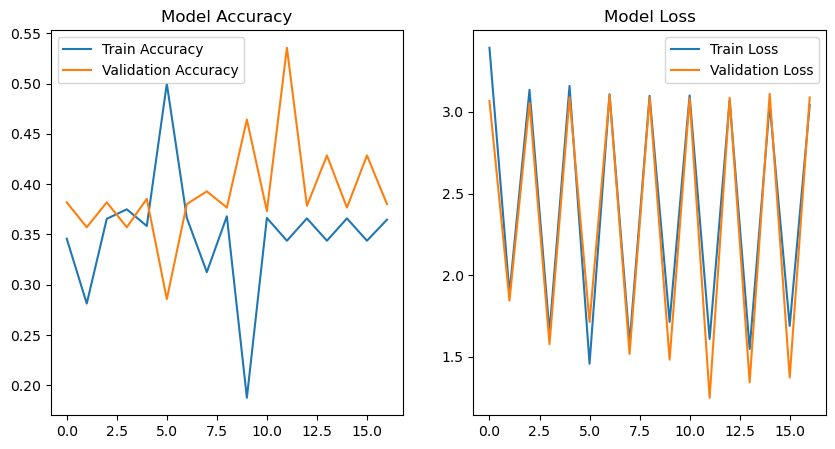

In [26]:
# Plot accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.legend()
plt.show()


#### Verifing predictions

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 259ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


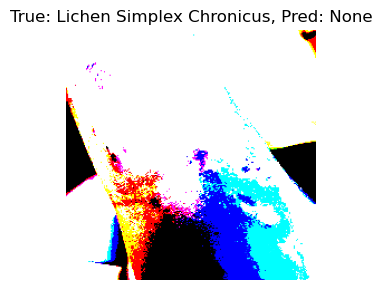

In [31]:
# Predict classes for the entire test dataset
all_predictions = model.predict(X_test)
all_predicted_classes = np.argmax(all_predictions, axis=1)

# Randomly select 1 indices from the available predictions
selected_indices = np.random.choice(range(len(X_test)), size=min(1, len(X_test)), replace=False)

# Select images and predictions based on these indices
sample_images = X_test[selected_indices]
sample_predictions = all_predictions[selected_indices]
sample_predictions_classes = np.argmax(sample_predictions, axis=1)

# Class names from LabelEncoder
class_names = encoder.classes_

# Visualization function
def plot_predictions(images, true_labels, predictions, class_names):
    num_images = len(images)
    fig, axes = plt.subplots(nrows=num_images, ncols=1, figsize=(5, num_images * 3))
    if num_images == 1:
        axes = [axes]  # Ensure axes is iterable even if only one image
    
    for i, ax in enumerate(axes):
        img = images[i]
        if img.dtype != np.float32:
            img = img.astype(np.float32) / 255  # Ensure image is properly scaled for display
        ax.imshow(img)  # Assume images are in RGB format
        true_label_name = class_names[true_labels[i]]
        predicted_label_name = class_names[predictions[i]]
        ax.set_title(f"True: {true_label_name}, Pred: {predicted_label_name}")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function to plot predictions
plot_predictions(sample_images, y_test[selected_indices], sample_predictions_classes, class_names)


#### Evaluation Metrics

In [37]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Calculate accuracy on the test set
test_accuracy = accuracy_score(y_test, all_predicted_classes)
print(f"Accuracy: {test_accuracy:.2f}")

Accuracy: 0.38


Upon reflection, the achieved accuracy of 0.38 in the convolutional neural network (CNN) model for classifying skin conditions from the Skin Condition Image Network (SCIN) dataset points towards several underlying challenges. These challenges include primarily the quality of images and the extent of missing data within the dataset.

Our proposed hybrid model, integrating CNN and LSTM components, was designed to be evaluated using precision metrics like accuracy, precision, recall, F1-score for the CNN, and RMSE and MAE for the LSTM. However, the project faced significant challenges that impacted the realization of this model:

Inefficient Time Intervals: The condition_duration data essential for LSTM training had inconsistent intervals, complicating effective model training.

Prevalence of Missing Values: Extensive missing data in critical features adversely affected both the CNN and LSTM components, leading to potential biases and inaccuracies.

Poor Image Quality: The CNN's performance was particularly hindered by the low resolution of images, crucial for accurate feature extraction and classification.

These limitations led to an inability to fully achieve the model's goals of accurate skin condition classification and progression prediction. Moving forward, enhancing data quality, employing advanced preprocessing techniques, and iterative model refinement are recommended to address these issues. By improving dataset integrity and model training processes, we aim to enhance the reliability and effectiveness of our AI-driven diagnostic tools in dermatology.

### Conclusion

This project aimed to develop a hybrid machine learning model integrating a Convolutional Neural Network (CNN) and a Long Short-Term Memory (LSTM) network for classifying skin conditions and predicting disease progression. Despite facing significant challenges such as data quality issues and inconsistencies in critical data fields, the project demonstrated the potential of AI in dermatological diagnosis. The CNN component highlighted how machine learning could aid in the visual classification of skin conditions, providing foundational insights. However, the LSTM model's effectiveness was limited due to data quality, particularly in `condition_duration` and image resolution. Moving forward, improving dataset quality and refining model architectures will be crucial. These steps will enhance the accuracy and reliability of the models, underscoring the transformative potential of AI in healthcare diagnostics. This project lays a solid groundwork for future advancements in AI-driven dermatological solutions.